In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report, auc, ConfusionMatrixDisplay, confusion_matrix

In [2]:
features_data = pd.read_csv('features_dataset.csv', index_col='Unnamed: 0')
features_data

,trunk_rotated,trunk_angle,trunk_neck_angle,neck_rotated,neck_angle,left_upper_arm_angle,right_upper_arm_angle,left_elbow_lateral,right_elbow_lateral,left_elbow_angle,right_elbow_angle,left_thigh_horizontal,right_thigh_horizontal,left_thigh_angle,right_thigh_angle,left_knee_angle,right_knee_angle,file,class
0,False,-12.652557,164.621133,False,2.726311,NaN,4.994930,False,False,NaN,117.448095,True,False,115.788245,109.636855,108.188880,95.586732,2023-06-03 17_22_13.112711.jpeg,False
1,False,-15.575580,162.662029,False,1.762391,3.340916,1.934466,False,False,118.765124,NaN,False,True,109.801427,120.980451,95.684195,113.092922,2023-06-03 17_22_13.112711_flipped.jpeg,False
2,False,-12.965854,165.271755,False,1.762391,95.016823,1.447090,False,False,33.570642,122.647888,True,True,116.237576,110.891171,108.795887,95.860740,2023-06-03 17_22_17.757394.jpeg,False
3,False,-15.972132,164.882965,False,-0.855097,2.045408,0.460378,False,False,123.009165,136.770369,True,True,111.057290,121.198162,94.346163,112.932100,2023-06-03 17_22_17.757394_flipped.jpeg,False
4,False,-14.083207,165.916793,False,0.000000,94.014176,2.935079,False,False,33.146996,121.200515,True,True,117.661293,113.097418,108.800467,96.825738,2023-06-03 17_22_22.021098.jpeg,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,False,-36.511056,124.074408,True,NaN,7.848869,6.584291,False,False,119.046617,159.401103,True,True,131.027862,146.181004,92.743002,100.109877,2023-06-03 17_43_12.454900_flipped.jpeg,True
1000,False,-33.578814,132.606161,False,13.815025,9.659083,4.005279,False,False,123.754517,104.563287,True,True,132.836774,134.382812,96.873458,94.121014,2023-06-03 17_43_15.425038.jpeg,True
1001,False,-34.077195,121.640547,True,NaN,1.877877,10.937249,False,False,102.142583,119.687835,True,True,134.168224,135.879713,93.692613,101.309932,2023-06-03 17_43_15.425038_flipped.jpeg,True
1002,False,-33.801973,45.217377,True,NaN,7.712980,0.432855,False,False,120.924912,99.263552,True,True,133.487912,134.975164,96.958847,94.319894,2023-06-03 17_43_18.604325.jpeg,True


In [3]:
target = features_data['class']
print('target:', target.shape)
data = features_data.drop(['file', 'class'], axis=1)
print('data:', data.shape)

target: (1004,)
data: (1004, 17)


In [4]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=34, shuffle=True, stratify=target)
print('data train:', data_train.shape)
print('data test:', data_test.shape)
print('target train:', target_train.shape)
print('target test:', target_test.shape)

data train: (803, 17)
data test: (201, 17)
target train: (803,)
target test: (201,)


In [5]:
knn_imputer = KNNImputer()
mm_scaler = MinMaxScaler()

columns = ['trunk_rotated', 'neck_rotated', 'left_thigh_horizontal', 'right_thigh_horizontal']
pipeline = Pipeline(
    [
        ('knn_imputer', knn_imputer),
        ('min_max_scaler', mm_scaler)
    ]
)

X = pipeline.fit_transform(data_train)
data_train = pd.DataFrame(X, columns=data_train.columns)
data_train

,trunk_rotated,trunk_angle,trunk_neck_angle,neck_rotated,neck_angle,left_upper_arm_angle,right_upper_arm_angle,left_elbow_lateral,right_elbow_lateral,left_elbow_angle,right_elbow_angle,left_thigh_horizontal,right_thigh_horizontal,left_thigh_angle,right_thigh_angle,left_knee_angle,right_knee_angle
0,0.0,0.159797,0.976993,0.0,0.977735,0.064755,0.026933,0.0,0.0,0.888380,0.770940,1.0,1.0,0.834350,0.685262,0.540647,0.488960
1,0.0,0.165099,0.000000,1.0,0.740008,0.046488,0.002317,0.0,0.0,0.668455,0.527577,1.0,1.0,0.794601,0.698785,0.494345,0.439737
2,0.0,0.506562,0.960807,0.0,0.428330,0.233845,0.166389,0.0,0.0,0.354176,0.381850,0.0,1.0,0.519045,0.509654,0.561542,0.503595
3,0.0,0.514456,0.935944,0.0,0.481715,0.090540,0.046606,0.0,0.0,0.537605,0.564377,1.0,1.0,0.586472,0.542229,0.514624,0.546272
4,0.0,0.323676,0.872572,0.0,0.405168,0.365338,0.366676,0.0,0.0,0.960324,0.929158,1.0,1.0,0.722747,0.586509,0.441823,0.395337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,0.0,0.520386,0.903282,0.0,0.547371,0.079714,0.008859,0.0,0.0,0.567345,0.715339,1.0,1.0,0.569400,0.540373,0.521239,0.545313
799,0.0,0.487316,0.911163,0.0,0.499632,0.062531,0.018385,0.0,0.0,0.603956,0.496782,1.0,1.0,0.641924,0.504950,0.624288,0.492023
800,0.0,0.995902,0.962492,0.0,0.918577,0.131952,0.130744,0.0,0.0,0.357086,0.325864,0.0,0.0,0.193393,0.153341,0.508530,0.511924
801,1.0,0.242594,0.822501,1.0,0.267935,0.104437,0.067296,0.0,0.0,0.597349,0.674171,1.0,1.0,0.658594,0.575628,0.371899,0.274581


In [6]:
X = pipeline.transform(data_test)
data_test = pd.DataFrame(X, columns=data_test.columns)
data_test

,trunk_rotated,trunk_angle,trunk_neck_angle,neck_rotated,neck_angle,left_upper_arm_angle,right_upper_arm_angle,left_elbow_lateral,right_elbow_lateral,left_elbow_angle,right_elbow_angle,left_thigh_horizontal,right_thigh_horizontal,left_thigh_angle,right_thigh_angle,left_knee_angle,right_knee_angle
0,0.0,0.490662,0.912663,0.0,0.500266,0.065526,0.012116,0.0,0.0,0.599417,0.496659,1.0,1.0,0.639784,0.499655,0.623011,0.491256
1,0.0,0.509948,0.962676,0.0,0.428330,0.095809,0.009418,0.0,0.0,0.590498,0.812490,1.0,1.0,0.574747,0.567465,0.530971,0.575642
2,0.0,0.160524,0.915222,0.0,0.162764,0.189130,0.112360,0.0,0.0,0.798856,0.728903,1.0,1.0,0.787364,0.707379,0.481153,0.684563
3,0.0,0.506461,0.898321,0.0,0.542396,0.055347,0.005595,0.0,0.0,0.579014,0.492326,1.0,0.0,0.593317,0.459906,0.565146,0.482181
4,0.0,0.319073,0.860868,0.0,0.421912,0.312411,0.375844,0.0,1.0,0.946522,0.949965,1.0,1.0,0.724417,0.590281,0.439241,0.394170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.0,0.497141,0.911976,0.0,0.508053,0.086132,0.047785,0.0,0.0,0.570536,0.683029,1.0,1.0,0.596025,0.564393,0.522735,0.545025
197,1.0,0.361580,0.199620,1.0,0.779567,0.222758,0.107063,0.0,0.0,0.412881,0.393982,1.0,0.0,0.659471,0.449600,0.539844,0.481572
198,0.0,0.335003,0.871283,0.0,0.418944,0.372854,0.363499,0.0,0.0,0.902283,0.950352,1.0,1.0,0.722867,0.594955,0.424127,0.419405
199,0.0,0.556470,0.957088,0.0,0.485440,0.022038,0.088796,0.0,0.0,0.501286,0.516965,0.0,0.0,0.543811,0.453260,0.527050,0.586304


In [7]:
classifier = xgb.XGBClassifier(random_state=34)

cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=34)

def bayesian_search_callback(results):

    all_scores = results['func_vals']

    best_score = results['fun']
    best_parameters = results['x']

    current_parameters = results['x_iters']

    print(f'Model #{len(all_scores)}:')
    print(f'Current Score: {-all_scores[-1]}')
    print(f'Current Parameters: {current_parameters[-1]}')
    print(f'Best Score: {-best_score}')
    print(f'Best Parameters: {best_parameters}\n')

space = {
    'n_estimators': Integer(100, 200),
    'max_depth': Integer(1, 25),
    'learning_rate': Real(1e-4, 1e-1, 'log-uniform'),
    'gamma': Real(0.05, 1.0),
    'min_child_weight': Integer(1, 50),
    'subsample': Real(0.05, 1.0),
    'colsample_bytree': Real(0.06, 1.0)
}

optimization = BayesSearchCV(
    classifier,
    space,
    n_iter=100,
    cv=cross_validation,
    random_state=34,
    n_jobs=-1,
    scoring='f1',
    return_train_score=True,
    refit=True
)

optimization.fit(data_train, target_train, callback=[bayesian_search_callback])

print(f'Best Parameters: {optimization.best_params_}')
print(f'Best Score: {optimization.best_score_}')
print(f'Best Estimator: {optimization.best_estimator_}')

Model #1:
Current Score: 0.9894358254358254
Current Parameters: [0.2685312423103485, 0.2959959195329342, 0.007819993682661562, 3, 11, 102, 0.5550599996753738]
Best Score: 0.9894358254358254
Best Parameters: [0.2685312423103485, 0.2959959195329342, 0.007819993682661562, 3, 11, 102, 0.5550599996753738]

Model #2:
Current Score: 0.976852616626101
Current Parameters: [0.914872574013454, 0.1820706565185377, 0.0005036156126553225, 24, 9, 115, 0.5931573862041036]
Best Score: 0.9894358254358254
Best Parameters: [0.2685312423103485, 0.2959959195329342, 0.007819993682661562, 3, 11, 102, 0.5550599996753738]

Model #3:
Current Score: 0.9041506942079891
Current Parameters: [0.19238790589325003, 0.9769039266392116, 0.0031419725073038667, 7, 47, 151, 0.6057047185873693]
Best Score: 0.9894358254358254
Best Parameters: [0.2685312423103485, 0.2959959195329342, 0.007819993682661562, 3, 11, 102, 0.5550599996753738]

Model #4:
Current Score: 0.8828164742190164
Current Parameters: [0.0915876370504449, 0.244

In [8]:
target_predicted = optimization.best_estimator_.predict(data_test)
target_predicted_prob = optimization.best_estimator_.predict_proba(data_test)

              precision    recall  f1-score   support

       False       1.00      0.99      1.00       104
        True       0.99      1.00      0.99        97

    accuracy                           1.00       201
   macro avg       0.99      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

AUC: 1.0


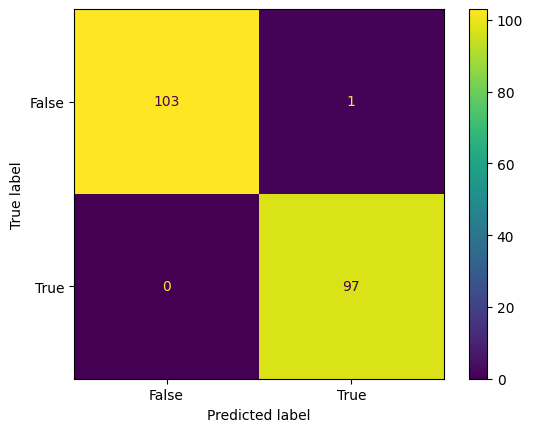

In [9]:
precision, recall, threshold = precision_recall_curve(target_test, target_predicted_prob[:, 1])
print(classification_report(target_test, target_predicted))
print(f'AUC: {round(auc(recall, precision), 2)}')
conf_matrix = confusion_matrix(target_test, target_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=optimization.classes_)
disp.plot()
plt.show()

In [10]:
file = 'posture_classification/pipeline.pkl'
pickle.dump(pipeline, open(file, 'wb'))

file = 'posture_classification/classifier.model'
optimization.best_estimator_.save_model(file)